# 기본 라이브러리 설치

In [36]:
!pip install kaggle

# Standard Dog Dataset를 캐글에서 불러오기

In [37]:
import os
os.environ['KAGGLE_USERNAME'] = 'matalcross'
os.environ['KAGGLE_KEY'] = 'eb178ab1c531b0b78cbefced1cb26c06'

In [38]:
!kaggle competitions download -c dog-breed-identification

401 - Unauthorized


# labels.csv 파일의 내용 확인

In [39]:
import pandas as pd
label_text = pd.read_csv('./dog-breed-identification/labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


# labels.csv 정보 확인

In [40]:
label_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


# 견종 수 확인

In [41]:
label_text['breed'].nunique()

120

# 이미지 확인

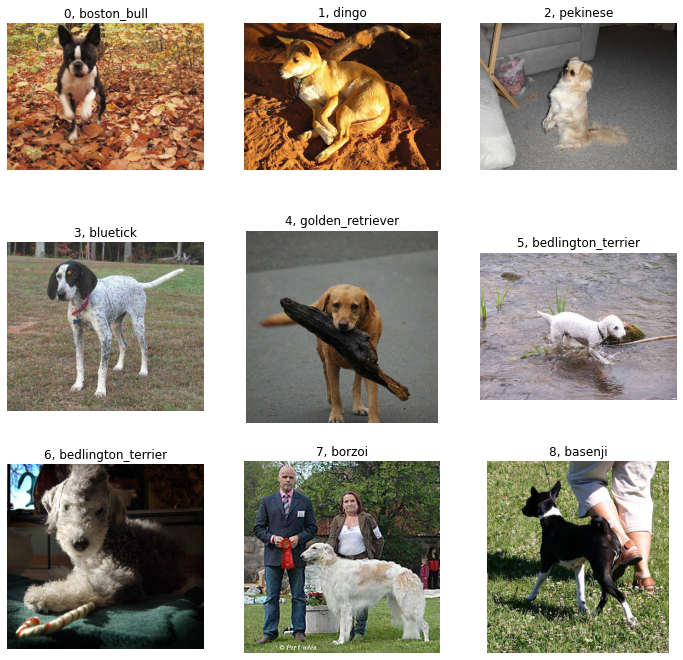

In [42]:
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
for c in range(9):
    image_id = label_text.loc[c, 'id']
    plt.subplot(3,3,c+1)
    plt.imshow(plt.imread('./dog-breed-identification/train/' + image_id + '.jpg'))
    plt.title(str(c) + ', ' + label_text.loc[c, 'breed'])
    plt.axis('off')
    
plt.show()

# tf.keras에서 MobileNet V2 불러오기

In [43]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

# MobileNet V2의 가중치 초기화

In [44]:
import numpy as np
import tensorflow as tf

for layer in mobilev2.layers[:-1]:
    layer.trainable = True
    
for layer in mobilev2.layers[:-1]:
    if 'kernel' in layer.__dict__:
        kernel_shape = np.array(layer.get_weights()).shape
        # weight를 평균이 0, 표준편차가 1인 random 변수로 초기화
        layer.set_weights(tf.random.normal(kernel_shape, 0, 1))

# 훈련 데이터를 메모리에 로드

In [45]:
import cv2

train_X = []
for i in range(len(label_text)):
    img = cv2.imread('./dog-breed-identification/train/' + label_text['id'][i] + '.jpg')
    img = cv2.resize(img, dsize=(224,224))
    img = img / 255.0
    train_X.append(img)
    
train_X = np.array(train_X)
print(train_X.shape)
print(train_X.size * train_X.itemsize, ' bytes')

(10222, 224, 224, 3)
12309577728  bytes


# train 라벨 데이터를 메모리에 로드

In [46]:
# 8.17 train 라벨 데이터를 메모리에 로드
unique_Y = label_text['breed'].unique().tolist()
train_Y = [unique_Y.index(breed) for breed in label_text['breed']]
train_Y = np.array(train_Y)

print(train_Y[:10])
print(train_Y[-10:])

[0 1 2 3 4 5 5 6 7 8]
[34 87 91 63 48  6 93 63 77 92]


# Dogs Dataset 학습을 위한 모델 정의

In [47]:
x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# 랜덤한 가중치를 가진 상태에서의 학습

In [48]:
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

Epoch 1/10


2022-03-01 20:29:08.030444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - ETA: 0s - loss: 4.8852 - accuracy: 0.0086

2022-03-01 20:31:36.874588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 164s 674ms/step - loss: 4.8852 - accuracy: 0.0086 - val_loss: 7.8920 - val_accuracy: 0.0067
Epoch 2/10
240/240 [==============================] - 159s 661ms/step - loss: 4.8588 - accuracy: 0.0097 - val_loss: 9.0492 - val_accuracy: 0.0137
Epoch 3/10
240/240 [==============================] - 156s 649ms/step - loss: 4.8455 - accuracy: 0.0098 - val_loss: 6.6254 - val_accuracy: 0.0102
Epoch 4/10
240/240 [==============================] - 156s 652ms/step - loss: 4.8441 - accuracy: 0.0093 - val_loss: 6.7033 - val_accuracy: 0.0106
Epoch 5/10
240/240 [==============================] - 158s 657ms/step - loss: 4.8440 - accuracy: 0.0119 - val_loss: 7.0490 - val_accuracy: 0.0098
Epoch 6/10
240/240 [==============================] - 173s 723ms/step - loss: 4.8415 - accuracy: 0.0103 - val_loss: 7.1322 - val_accuracy: 0.0086
Epoch 7/10
240/240 [==============================] - 171s 712ms/step - loss: 4.8341 - accuracy: 0.0115 - val_loss: 6.9780 - val_accura

# 학습 결과 확인

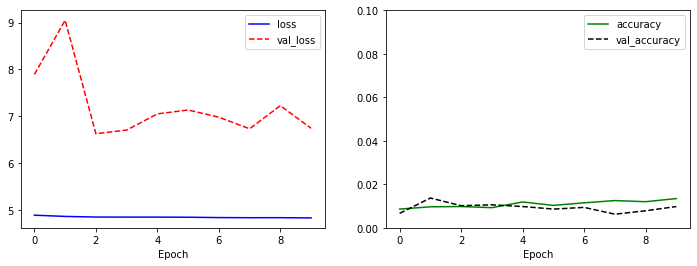

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 0.1)
plt.legend()

plt.show()

# Dogs Dataset 학습을 위한 전이 학습 모델 정의

In [50]:
# 8.21 Dogs Dataset 학습을 위한 Transfer Learning 모델 정의
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()

x = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense(120, activation='softmax')(x)
model = tf.keras.Model(inputs=mobilev2.input, outputs=predictions)

# 뒤에서 20개까지의 레이어는 훈련 가능, 나머지는 가중치 고정
for layer in model.layers[:-20]:
    layer.trainable = False
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) # 라벨이 원-핫 인코딩을 사용하기 때문에 sparse가 아닌 categorical_crossentropy를 사용합니다.
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# 모델 학습 및 결과 확인

Epoch 1/10


2022-03-01 20:58:47.766810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - ETA: 0s - loss: 4.8132 - accuracy: 0.0081

2022-03-01 20:59:44.598020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 77s 297ms/step - loss: 4.8132 - accuracy: 0.0081 - val_loss: 4.9226 - val_accuracy: 0.0215
Epoch 2/10
240/240 [==============================] - 71s 294ms/step - loss: 4.7508 - accuracy: 0.0171 - val_loss: 4.6731 - val_accuracy: 0.0552
Epoch 3/10
240/240 [==============================] - 102s 425ms/step - loss: 4.6981 - accuracy: 0.0292 - val_loss: 4.4222 - val_accuracy: 0.0966
Epoch 4/10
240/240 [==============================] - 91s 379ms/step - loss: 4.6462 - accuracy: 0.0436 - val_loss: 4.1607 - val_accuracy: 0.1385
Epoch 5/10
240/240 [==============================] - 89s 369ms/step - loss: 4.5965 - accuracy: 0.0574 - val_loss: 3.9426 - val_accuracy: 0.1643
Epoch 6/10
240/240 [==============================] - 78s 325ms/step - loss: 4.5536 - accuracy: 0.0668 - val_loss: 3.7791 - val_accuracy: 0.1808
Epoch 7/10
240/240 [==============================] - 73s 304ms/step - loss: 4.5224 - accuracy: 0.0762 - val_loss: 3.6351 - val_accuracy: 0.

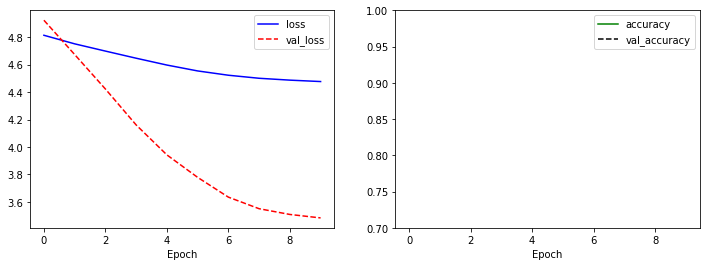

In [51]:
# 8.22 모델 학습 및 결과 확인
history = model.fit(train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()